In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import matplotlib as mpl
from textwrap import wrap
mpl.rcParams["font.family"] = "Times New Roman"
mpl.rcParams["font.sans-serif"] = "Times New Roman"
mpl.rcParams["font.size"] = 14
viridis_colors=['#440154', '#414487', '#2a788e', '#22a884', '#7ad151', '#fde725']

In [2]:
factor_explored = 'TrafficRange'

In [3]:
def read_and_merged(merged_df, base_path, file_name, xlsx_name, columns_of_interest, aggregate_with = "mean"):
    file_path = base_path + file_name + '/' + xlsx_name + '.xlsx'
    datafile =  pd.read_excel(file_path)
    if aggregate_with=="mean":
        datafile = datafile.groupby("Replication Id")[columns_of_interest].mean().reset_index()
    elif aggregate_with=="sum":
        datafile = datafile.groupby("Replication Id")[columns_of_interest].sum().reset_index()
    merged_df = pd.merge(merged_df, datafile, on=['Replication Id'], how='right')
    return merged_df

In [7]:
merged_dfs = []
run_length = 28 #days
no_chambers = 3
periodic_duration = 2 #hours

# base_path = "Data/Experiments/Screening/"
regime = '40_80_10'
fleet_mix = 'AlternativeFleetMix'
base_path = "data/Experiments/UnivariateAnalysis/" + factor_explored

for i, base_path in enumerate(["data/Experiments/UnivariateAnalysis/Baseline7day", "data/Experiments/UnivariateAnalysis/" + factor_explored]):
    input_file_path = base_path + '/Scenario Parameters.xlsx'
    input_df =  pd.read_excel(input_file_path, index_col=0)
    no_set_per_file = len(input_df)
    input_df['FleetMix'] = fleet_mix
    input_df['LockingRegime'] = regime

    kpi_file_path = base_path + '/KPI Locks Summary.xlsx'
    kpi_df =  pd.read_excel(kpi_file_path, index_col=0)
    kpi_df['SetNo'] = 1 + (kpi_df.index -1) % no_set_per_file

    # Adding Emission calculation to kpi_df
    file_path = base_path + '/KPI Emissions Locks.xlsx'
    datafile =  pd.read_excel(file_path)
    datafile = datafile[datafile["Emission substance"]== "CO2"].loc[:,["Replication Id", "Emissions slowsteaming (kg/day)"]]
    kpi_df = pd.merge(kpi_df, datafile, on=['Replication Id'], how='right')

    # Merging these two dataframes
    merged_df = pd.merge(input_df, kpi_df, on=['SetNo'], how='right')
    merged_df['SetNo'] = merged_df['SetNo'] + i
    merged_dfs.append(merged_df)

    experiments = pd.concat(merged_dfs)
    # del(merged_dfs)
    experiments.describe()

In [8]:
experiments['LockCondition'] = experiments.apply(lambda x: 
                                           '0_control' if ((x['FlutteringProbability']==0) and (x['SlowDownEffect']==0))
                                           else('1_fluttering_only' if ((x['FlutteringProbability']==0.015) and (x['SlowDownEffect']==0))
                                                else '2_slowdown_only' if ((x['FlutteringProbability']==0) and (x['SlowDownEffect']!=0))
                                                else '3_both' if (x['FlutteringProbability']==0.015) else 
                                                '4_extreme' if (x['FlutteringProbability']==0.03) else 'faulty'), axis=1)

In [9]:
experiments['Avg lockage time (minutes)'] = 60*experiments['Total Leveling Time (hours)']/experiments['Amount of ships']
experiments.rename(columns={
    'Amount of ships':'Number of ships',
    'Amount of levelings' : 'Number of levelings',
    'Amount of empty levelings (%)' : 'Number of empty levelings (%)',
    'Emissions slowsteaming (kg/day)' : 'CO2 emissions (kg/day)',
    }, inplace=True)

In [10]:
cols_KPIs = ['CO2 emissions (kg/day)',
    'Avg lockage time (minutes)',
    'Avg waiting time (minutes)',
    'Number of levelings']
# To discuss in relation with 'Avg waiting time (minutes)' : 'Max number of ships waiting', 'Service Level (%)'
cols_waiting = ['Avg waiting time (minutes)',
    'Max number of ships waiting',
    'Service Level (%)']

In [11]:
cols_outcomes = list(experiments.columns[14:])
cols_outcomes

['Number of ships',
 'Number of levelings',
 'Number of empty levelings (%)',
 'Avg Occupancy (%)',
 'Max number of ships waiting',
 'Avg passage time (minutes)',
 'Avg waiting time (minutes)',
 'Service Level (%)',
 'Total Waiting Time (hours)',
 'Total Leveling Time (hours)',
 'Avg ships per leveling',
 'Avg ships per filled leveling',
 'CO2 emissions (kg/day)',
 'LockCondition',
 'Avg lockage time (minutes)']

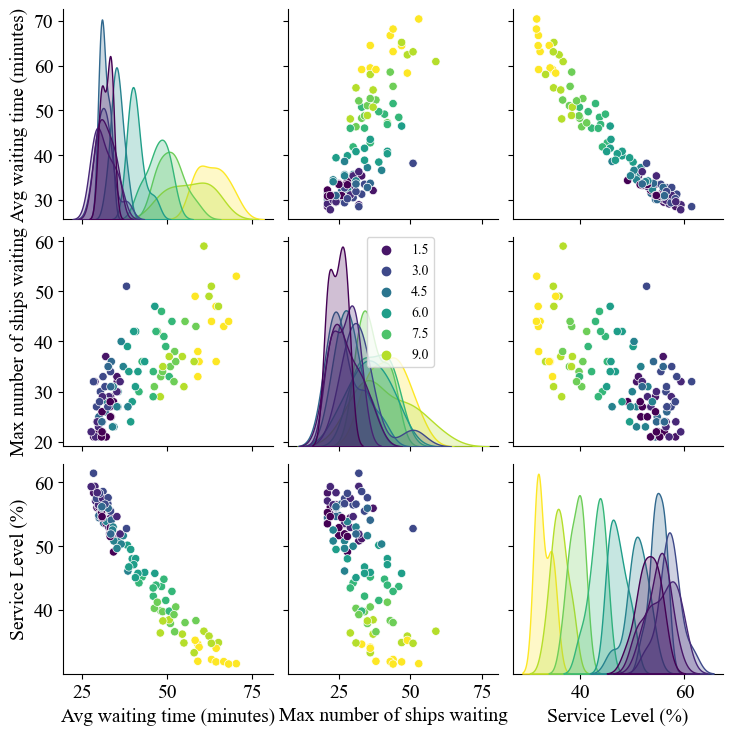

In [12]:
g = sns.pairplot(experiments.loc[:, cols_waiting + [factor_explored]], hue=factor_explored, palette= 'viridis')
# plt.tight_layout()
# plt.savefig('Figs/OutputAnalysis/FeatureScoringHighIntensity.pdf')
handles = g._legend_data.values()
labels = g._legend_data.keys()
g._legend.remove()
g.fig.legend(handles=handles, labels=labels, loc=(0.5, 0.5), ncol=1, fontsize=10)
plt.show()

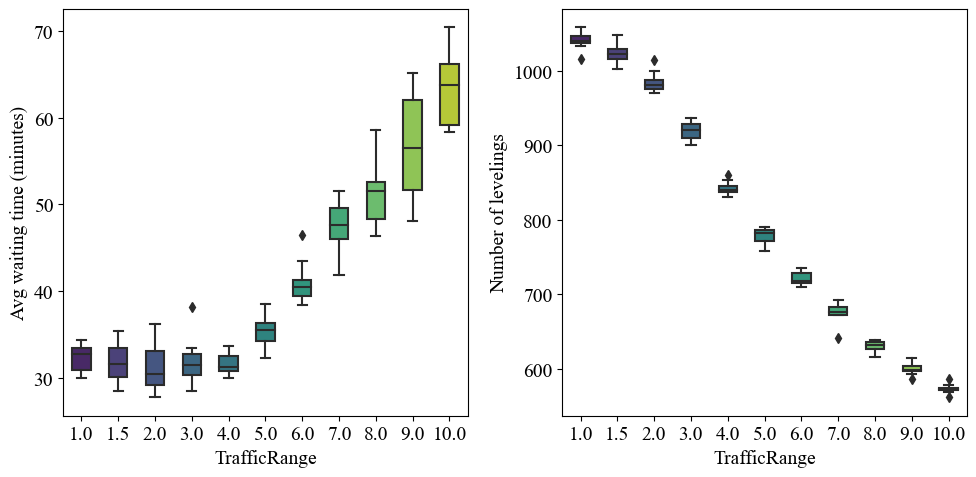

In [14]:
fig, axes = plt.subplots(1,2, figsize=(10, 5), sharey=False)
kpi_set = ['Avg waiting time (minutes)', 'Number of levelings']

for i, kpi in enumerate(kpi_set):
    sns.boxplot(ax= axes[i], y=kpi, x=factor_explored, data=experiments, 
                palette= 'viridis', width=0.5)

plt.tight_layout()
plt.savefig('output/figs/output_analysis/univariate_experiments/' + factor_explored + '/' + str(kpi_set) + '.pdf', bbox_inches='tight')
plt.show()

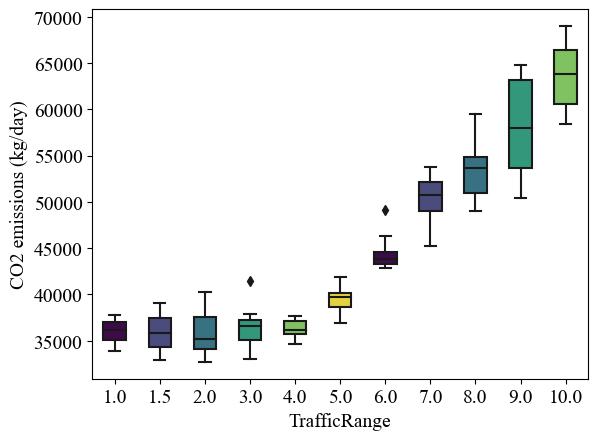

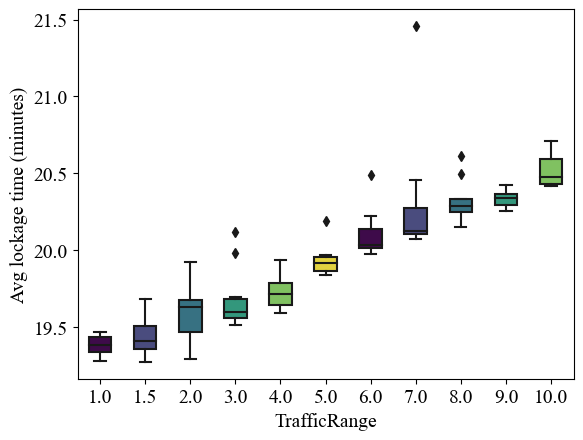

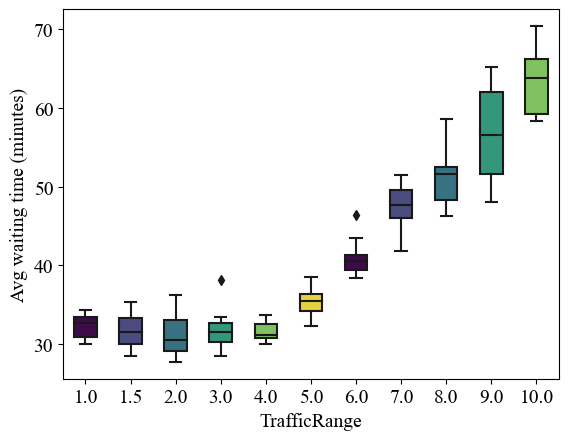

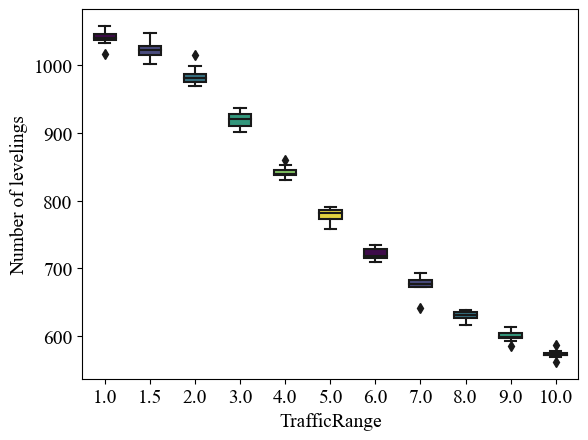

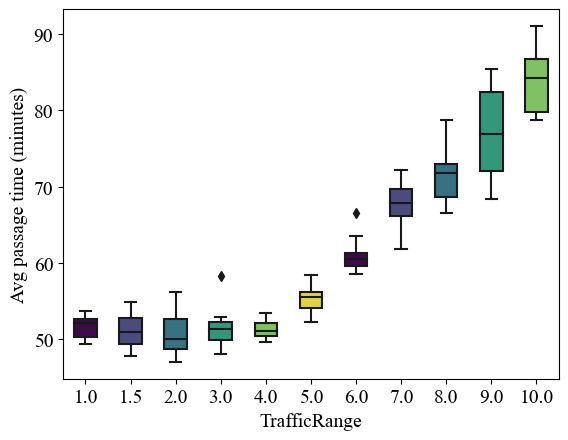

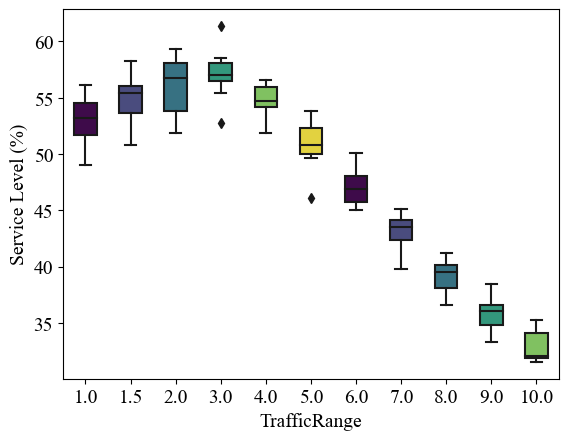

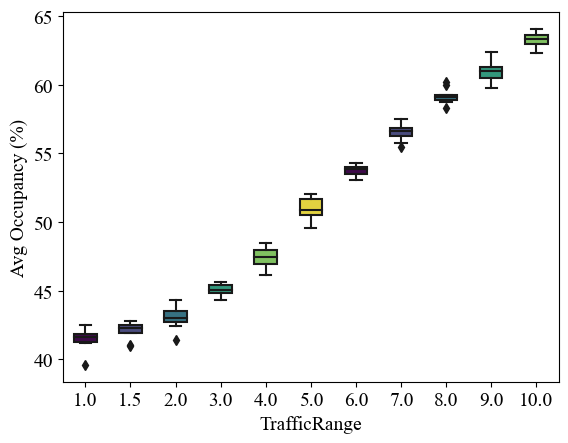

In [15]:
for kpi in cols_KPIs + ['Avg passage time (minutes)','Service Level (%)', 'Avg Occupancy (%)']:
    sns.boxplot(y=kpi, x=factor_explored, data=experiments, palette=viridis_colors, width=0.5)
    plt.show()
